# Impact of factors on retention

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
#import geopandas as gpd

Read turnover data from csv into a dataframe.

In [29]:
#month = "february"
#year = "2023"
url = f'../01_data/processed_monthly_turnover.csv'
df = pd.read_csv(url, parse_dates=['month_year'])
#df = df.sort_values(by='Date')
df = df.drop(['n'],axis=1)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145156 entries, 0 to 145155
Data columns (total 11 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   org_code     145156 non-null  object        
 1   region_name  145156 non-null  object        
 2   org_type     145156 non-null  object        
 3   staff_group  145156 non-null  object        
 4   month_year   145156 non-null  datetime64[ns]
 5   join_HC      108508 non-null  float64       
 6   join_FTE     108508 non-null  float64       
 7   leave_HC     108678 non-null  float64       
 8   leave_FTE    108678 non-null  float64       
 9   denom_HC     144909 non-null  float64       
 10  denom_FTE    144909 non-null  float64       
dtypes: datetime64[ns](1), float64(6), object(4)
memory usage: 12.2+ MB


Calculate a leaver and joiner rate, drop FTE and HC columns

In [30]:
df['leaver_rate'] = df['leave_FTE']/df['denom_FTE']
df['joiner_rate'] = df['join_FTE']/df['denom_FTE']

df.replace([np.inf, -np.inf], np.nan, inplace=True)

df['leaver_rate'].fillna(0, inplace=True)
df['joiner_rate'].fillna(0, inplace=True)

df = df.drop(['join_HC','join_FTE','leave_HC',
              'leave_FTE'],axis=1)


In [31]:
df['staff_group'].unique()

array(['All staff groups', 'Ambulance staff', 'Central functions',
       'HCHS doctors (exc. junior Drs)', 'Hotel, property & estates',
       'Managers', 'Midwives', 'Nurses & health visitors',
       'Other staff or those with unknown classification',
       'Scientific, therapeutic & technical staff', 'Senior managers',
       'Support to ST&T staff', 'Support to doctors, nurses & midwives',
       'Support to ambulance staff'], dtype=object)

Calculate a total staff in post (SIP; all staff) FTE column for each organisation by month.

In [33]:

# Set the 'total_sip_FTE' value to be equal to the 'FTE' value for 'All staff groups' 
allstaff_fte = df.loc[df['staff_group'] == 'All staff groups',
                      ['month_year', 'org_code', 'denom_FTE']].groupby(['month_year', 'org_code'])['denom_FTE'].sum().reset_index()

allstaff_fte.rename(columns={'denom_FTE':'total_sip_FTE'},inplace=True)


df = pd.merge(df, allstaff_fte, on=['month_year', 'org_code'], how='left')


In [36]:
#drop denom FTE and HC
df = df.drop(['denom_HC','denom_FTE'],axis=1)

In [37]:
df.head()

,org_code,region_name,org_type,staff_group,month_year,leaver_rate,joiner_rate,total_sip_FTE
0,R0A,North West,Acute - Teaching,All staff groups,2019-07-01,0.012726,0.012107,17710.16849
1,R0A,North West,Acute - Teaching,All staff groups,2019-08-01,0.015480,0.023155,17688.67573
2,R0A,North West,Acute - Teaching,All staff groups,2019-09-01,0.013685,0.023582,17827.49574
3,R0A,North West,Acute - Teaching,All staff groups,2019-10-01,0.011069,0.016197,17998.03831
4,R0A,North West,Acute - Teaching,All staff groups,2019-11-01,0.010922,0.012918,18083.50226


The data show the full time equivalent (FTE) number of leavers by organisation and staff group for the previous 12-month period from the date. It also shows the number of staff in post (SIP) FTE averaged over the 12-month period to date.

Load data about local unemployment so we can use it as a regressor

In [38]:
url_r1 = '../01_data/ONS_localunemployment_monthly.csv'
df_r1 = pd.read_csv(url_r1, parse_dates=['Date'])

df_r1.tail()

,Date,Region,NHSE region name,%,thousands
3343,2023-03-01,North West,North West,0.030,107
3344,2023-03-01,South East,South East,0.037,177
3345,2023-03-01,South West,South West,0.031,89
3346,2023-03-01,West Midlands,Midlands,0.048,147
3347,2023-03-01,York & the Humber,North East and Yorkshire,0.038,104


In [39]:
df_r1.drop(['Region','thousands'],axis=1,inplace=True)
df_r1.rename(columns={'%':'local_unemployment','Date':'month_year',
                      'NHSE region name':'region_name'},inplace=True)
df_r1 = df_r1.sort_values('month_year')
df_r1.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3348 entries, 0 to 3347
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   month_year          3348 non-null   datetime64[ns]
 1   region_name         3348 non-null   object        
 2   local_unemployment  3348 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 104.6+ KB


Add data about local unemployment at the regional level to the main dataframe

In [40]:
df_leaver_r1 = pd.merge(df, df_r1, on=['month_year', 'region_name'],how='left')
#df_leaver_r1 = df_leaver_r1.dropna()
df_leaver_r1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 166685 entries, 0 to 166684
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            166685 non-null  object        
 1   region_name         166685 non-null  object        
 2   org_type            166685 non-null  object        
 3   staff_group         166685 non-null  object        
 4   month_year          166685 non-null  datetime64[ns]
 5   leaver_rate         166685 non-null  float64       
 6   joiner_rate         166685 non-null  float64       
 7   total_sip_FTE       166685 non-null  float64       
 8   local_unemployment  139168 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(4)
memory usage: 11.4+ MB


In [41]:
df_leaver_r1 = df_leaver_r1.sort_values('month_year')
df_leaver_r1.tail()

,org_code,region_name,org_type,staff_group,month_year,leaver_rate,joiner_rate,total_sip_FTE,local_unemployment
25222,RCF,North East and Yorkshire,Acute - Small,Central functions,2024-02-01,0.0,0.0,3025.58627,NaN
103597,RTH,South East,Acute - Teaching,Midwives,2024-02-01,0.0,0.0,11593.99306,NaN
25166,RCF,North East and Yorkshire,Acute - Small,Ambulance staff,2024-02-01,0.0,0.0,3025.58627,NaN
104561,RTK,South East,Acute - Medium,Senior managers,2024-02-01,0.0,0.0,3919.26900,NaN
166684,TAJ,Midlands,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",2024-02-01,0.0,0.0,3434.33954,NaN


Load data about sickness absence to use as second regressor

In [47]:
url_r2 = '../01_data/sickness_absence.csv'
df_r2 = pd.read_csv(url_r2, parse_dates=['Date'])
trust_types_todrop = ['Clinical Commissioning Group','Integrated Care Board']
df_r2 = df_r2[~df_r2['Cluster group'].isin(trust_types_todrop)]
df_r2 = df_r2.drop(['Benchmark group','Org name',
                    'NHSE region code','Cluster group'],axis=1)
df_r2.rename(columns={'Org code':'org_code','Date':'month_year',
                      'NHSE region name':'region_name','Staff group':'staff_group'},inplace=True)
df_r2 = df_r2.reset_index(drop=True)
df_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240359 entries, 0 to 240358
Data columns (total 6 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   month_year          240359 non-null  datetime64[ns]
 1   org_code            240359 non-null  object        
 2   region_name         240359 non-null  object        
 3   staff_group         240359 non-null  object        
 4   FTE days lost       240359 non-null  float64       
 5   FTE days available  240359 non-null  float64       
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 11.0+ MB


In [48]:
df_r2.head()

,month_year,org_code,region_name,staff_group,FTE days lost,FTE days available
0,2018-03-01,RT3,London,"Hotel, property & estates",202.97333,4692.62646
1,2018-03-01,0DE,Special Health Authorities and other statutory...,Managers,150.75336,7272.63377
2,2018-03-01,0DE,Special Health Authorities and other statutory...,Nurses & health visitors,35.64000,2327.04646
3,2018-03-01,0DE,Special Health Authorities and other statutory...,"Scientific, therapeutic & technical staff",10.39998,504.83363
4,2018-03-01,0DE,Special Health Authorities and other statutory...,Senior managers,0.00000,1106.63354


Add sickness absence data to the main dataframe

In [51]:
merge_cols = ['month_year', 'org_code','region_name','staff_group']
df_leaver_r2 = pd.merge(df_leaver_r1, df_r2, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
df_leaver_r2.drop_duplicates(subset=merge_cols)
df_leaver_r2['sickness_absence'] = df_leaver_r2['FTE days lost']/df_leaver_r2['FTE days available']
df_leaver_r2 = df_leaver_r2.drop(['FTE days lost',
                        'FTE days available'],axis=1)
df_leaver_r2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 216875 entries, 0 to 216874
Data columns (total 10 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            216875 non-null  object        
 1   region_name         216875 non-null  object        
 2   org_type            216875 non-null  object        
 3   staff_group         216875 non-null  object        
 4   month_year          216875 non-null  datetime64[ns]
 5   leaver_rate         216875 non-null  float64       
 6   joiner_rate         216875 non-null  float64       
 7   total_sip_FTE       216875 non-null  float64       
 8   local_unemployment  189358 non-null  float64       
 9   sickness_absence    143083 non-null  float64       
dtypes: datetime64[ns](1), float64(5), object(4)
memory usage: 16.5+ MB


Add data about reasons for sickness absence

In [86]:
url_r3 = '../01_data/sickness_absence_reason_pivot.csv'
df_r3 = pd.read_csv(url_r3, parse_dates=['Date'])
#df_r3 = df_r3.drop(['FTE days lost'],axis=1)
df_r3.rename(columns={'Date':'month_year','Staff group':'staff_group',
                      'FTE days lost':'fte_days_lost','Description':'reason'},inplace=True)
#df_r2 = df_r2.reset_index(drop=True)

# Replace NaN values with 0 
df_r3 = df_r3.fillna(0)
df_r3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1246 entries, 0 to 1245
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   month_year         1246 non-null   datetime64[ns]
 1   staff_group        1246 non-null   object        
 2   anxiety_stress     1246 non-null   float64       
 3   asthma             1246 non-null   float64       
 4   back_problems      1246 non-null   float64       
 5   blood_disorder     1246 non-null   float64       
 6   dental             1246 non-null   float64       
 7   endocrine          1246 non-null   float64       
 8   eye                1246 non-null   float64       
 9   gastro             1246 non-null   float64       
 10  gynaecological     1246 non-null   float64       
 11  headache_mig       1246 non-null   float64       
 12  infectious_dis     1246 non-null   float64       
 13  nervous_system     1246 non-null   float64       
 14  other   

Add sickness absence reason data to main dataframe

In [82]:
merge_cols = ['month_year','staff_group']
df_leaver_r3 = pd.merge(df_leaver_r2, df_r3, on=merge_cols,how='left')
#df_leaver_r2 = df_leaver_r2.dropna()
#df_leaver_r3.drop_duplicates(subset=merge_cols)
df_leaver_r3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 186374 entries, 0 to 186373
Data columns (total 29 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   org_code            186374 non-null  object        
 1   region_name         186374 non-null  object        
 2   org_type            186374 non-null  object        
 3   staff_group         186374 non-null  object        
 4   month_year          186374 non-null  datetime64[ns]
 5   leaver_rate         186374 non-null  float64       
 6   joiner_rate         186374 non-null  float64       
 7   total_sip_FTE       186374 non-null  float64       
 8   local_unemployment  186374 non-null  float64       
 9   sickness_absence    186374 non-null  float64       
 10  anxiety_stress      145885 non-null  float64       
 11  asthma              145885 non-null  float64       
 12  back_problems       145885 non-null  float64       
 13  blood_disorder      145885 no

In [83]:
df_leaver_r3['month_year'].max()
#date_max = df['Date'].max()

Timestamp('2023-02-01 00:00:00')

In [84]:
max_date = '2023-02-01'
df_leaver_r3 = df_leaver_r3[df_leaver_r3['month_year'] <= max_date]

In [79]:
#url = 'REF_SICK_ABSENCE_REASONS.csv'
#df_ref_reason = pd.read_csv(url)

#reason_short = sorted(df_ref_reason['reason_short'].unique())

In [93]:
# List of columns to replace NaN values with 0
#cols = ['local_unemployment','sickness_absence','leaver_rate','joiner_rate']

# Replace NaN values with 0 in the specified columns
df_leaver_r3[cols] = df_leaver_r3[cols].fillna(0)
#Replace all NaN with 0
df_leaver_r3 = df_leaver_r3.fillna(0)


df_leaver_r3.reset_index(drop=True)
df_leaver_r3.head()

,org_code,region_name,org_type,staff_group,month_year,leaver_rate,joiner_rate,total_sip_FTE,local_unemployment,sickness_absence,...,headache_mig,infectious_dis,nervous_system,other,other_msk,pregnancy_related,respiratory,skin_disorders,substance_abus,unknown
0,R0A,North West,Acute - Teaching,All staff groups,2019-07-01,0.012726,0.012107,17710.16849,0.041,0.049655,...,0.028534,0.007154,0.012672,0.096771,0.132680,0.033153,0.029796,0.010508,0.000491,0.061364
1,R0A,North West,Acute - Teaching,All staff groups,2019-07-01,0.012726,0.012107,17710.16849,0.041,0.049655,...,0.028534,0.007154,0.012672,0.096771,0.132680,0.033153,0.029796,0.010508,0.000491,0.061364
2,RYF,South West,Ambulance Trust,HCHS doctors (exc. junior Drs),2019-07-01,0.000000,0.000000,3936.03594,0.024,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,RJ1,London,Acute - Teaching,Support to ST&T staff,2019-07-01,0.025540,0.024972,13571.88100,0.046,0.036744,...,0.036262,0.008085,0.012279,0.087104,0.140422,0.028749,0.033503,0.011735,0.000447,0.045798
4,RJ1,London,Acute - Teaching,Support to ST&T staff,2019-07-01,0.025540,0.024972,13571.88100,0.046,0.036744,...,0.036262,0.008085,0.012279,0.087104,0.140422,0.028749,0.033503,0.011735,0.000447,0.045798


In [94]:
df_check = df_leaver_r2[['joiner_rate']]
mask = np.isinf(df_check) | np.isnan(df_check)
check = df_check[mask.any(axis=1)]

Explore independent and dependent variables

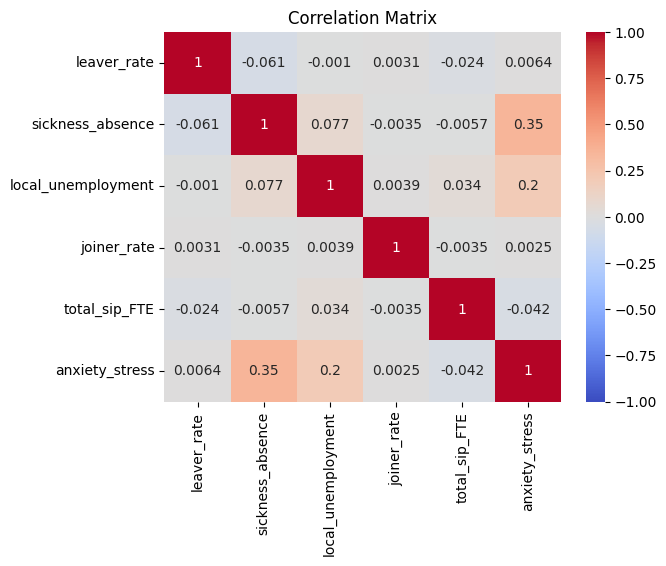

In [103]:
corr_cols = ['leaver_rate', 'sickness_absence',
                                   'local_unemployment','joiner_rate','total_sip_FTE','anxiety_stress']
correlation_matrix = df_leaver_r3[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Create a staff group level dataframe - specify which staff group you want from list below in variable staff_group

In [95]:
staff_group = 'Nurses & health visitors'
df_sg = df_leaver_r3[df_leaver_r3['staff_group'] == staff_group].copy()

#df_sg['sickness_absence_rate'] = df_sg['FTE days lost']/df_sg['FTE days available']
#df_sg['leaver_rate'] = df_sg['leave_FTE']/df_sg['denom_FTE']

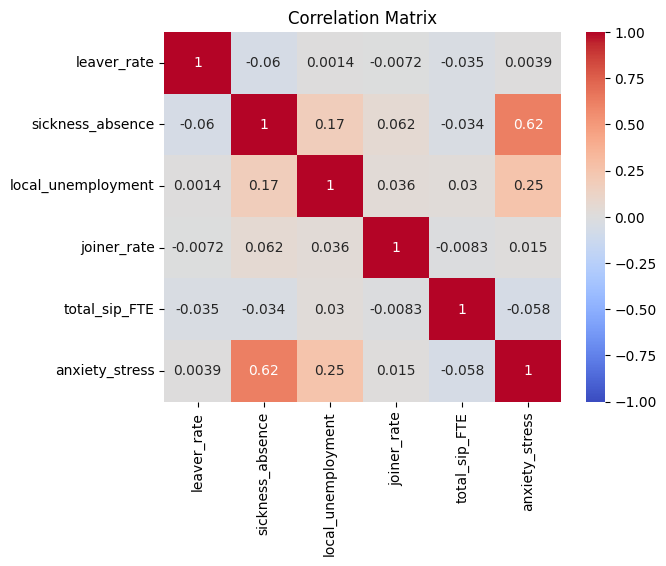

In [104]:
correlation_matrix = df_sg[corr_cols].corr()
# Create correlation matrix heatmap using Seaborn
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

(Optional) Create dummy variables for categorical independent variables

In [105]:
#ivs_cat = ['region_name','staff_group']
#df_with_dummies = pd.get_dummies(df_m, columns=ivs_cat, drop_first=True)
#df_with_dummies.head()

In [106]:
df_leaver_r3.to_csv(f'modelling_data_to_check.csv', index=False)

In [107]:
df_sg.to_csv(f'sg_modelling_data_to_check.csv', index=False)


Specify the dependent variable (dv) and independent variables (ivs). All other fields to be dropped. 

In [31]:
dv = 'leaver_rate'
ivs = ['local_unemployment','sickness_absence_rate','joiner_rate','sip_FTE']
to_drop = ['month_year','org_code','region_name','org_type','staff_group','n','join_HC',
           'join_FTE', 'leave_HC', 'leave_FTE', 'denom_HC','denom_FTE', dv]

Define the design matrix (X) and the dependent variable (y)


In [32]:
df_m.reset_index(drop = True)
X = df_m.drop(to_drop, axis=1)
y = df_m[dv]

#y = y.dropna()

y.head()


0    0.012726
1    0.012726
2    0.000000
3    0.025540
4    0.025540
Name: leaver_rate, dtype: float64

In [33]:

# Add a constant column to the design matrix
X = sm.add_constant(X)

X.tail()

# Convert True/False categories to integer 0/1
#bool_columns = X.select_dtypes(include='bool').columns
#X[bool_columns] = X[bool_columns].astype(int)


,const,local_unemployment,sickness_absence_rate,joiner_rate,sip_FTE
186369,1.0,0.047,0.0,0.029474,11801.00388
186370,1.0,0.040,0.0,0.000000,10855.67790
186371,1.0,0.047,0.0,0.000000,18436.42056
186372,1.0,0.040,0.0,0.013631,25969.82454
186373,1.0,0.047,0.0,0.030986,10783.64780


In [34]:
# Fit the regression model
model = sm.OLS(y, X)
results = model.fit()

# Print the regression results
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:            leaver_rate   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     206.6
Date:                Mon, 24 Jul 2023   Prob (F-statistic):          3.52e-177
Time:                        12:30:50   Log-Likelihood:             3.0535e+05
No. Observations:              186374   AIC:                        -6.107e+05
Df Residuals:                  186369   BIC:                        -6.106e+05
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.01

In [157]:

# Get the summary of the regression results
summary = results.summary()

# # Convert the summary table to a pandas DataFrame
# summary_df = pd.read_html(summary.tables[1].as_html(), header=0, index_col=0)[0]

# # Format the coefficients and p-values
# summary_df['coef'] = summary_df['coef'].map('{:.4f}'.format)
# summary_df['P>|t|'] = summary_df['P>|t|'].map('{:.4f}'.format)

# Print the formatted summary table
print(summary.tables[1])

                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                     0.0182      0.001     34.059      0.000       0.017       0.019
local_unemployment        0.0429      0.012      3.549      0.000       0.019       0.067
sickness_absence_rate    -0.1092      0.004    -27.670      0.000      -0.117      -0.101
joiner_rate               0.0002      0.000      1.234      0.217      -0.000       0.001
sip_FTE               -6.368e-08   6.22e-09    -10.236      0.000   -7.59e-08   -5.15e-08


This model uses region and type of provider to try and predict NHS staff leaver FTE. The R squared is 0.054, meaning the factors in the model only explain 5.4% of the variation in the data. A lower adjusted R squared than R squared would tell us that some of the model's factors are not contibuting - this is not the case here. 
All variables contribute significantly except being in the Midlands region, NE and Yorkshire, North West or South West.  
The strongest predictors are CCG